In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
def get_category(answer):
    answer = str(answer).lower()
    if answer in ["yes", "no"]:
        return "judge"
    elif answer in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]:
        return "count"
    else:
        return "query"
    
def get_evaluation(df):
    df["predicted"] = df["predicted"].astype(str).str.lower()
    df["actual"] = df["actual"].astype(str).str.lower()
    acc = (df["predicted"] == df["actual"]).sum() / len(df)
    judge_df = df[df["category"] == "judge"]
    count_df = df[df["category"] == "count"]
    query_df = df[df["category"] == "query"]

    acc_judge = (judge_df["predicted"] == judge_df["actual"]).sum() / len(judge_df)
    acc_count = (count_df["predicted"] == count_df["actual"]).sum() / len(count_df)
    acc_query = (query_df["predicted"] == query_df["actual"]).sum() / len(query_df)

    return {
        "total accuracy": acc,
        "judge_accuracy": acc_judge,
        "count_accuracy": acc_count,
        "query_accuracy": acc_query
    }

In [3]:
llms = ["gpt-4o-mini", "gpt-4o", "Qwen2.5-7B-Instruct-Turbo", "Qwen2.5-72B-Instruct-Turbo", "Meta-Llama-3.1-70B-Instruct-Turbo"]
approaches = ["direct", "routing", "state_machine", "react"]
runs = 3
result_folder = "results_new"

In [4]:
results = []

for llm in llms:
    for approach in approaches:
        approach_results = []
        for run in range(1, runs + 1):
            file_path = f"{result_folder}/{llm}/run{run}/{approach}.csv"
            if not os.path.exists(file_path):
                continue
            df = pd.read_csv(file_path)
            df["category"] = df["actual"].apply(get_category)
            # Calculate accuracy for each category
            evaluation = get_evaluation(df)
            if approach != "direct":
                evaluation["llm_calls"] = df["num_llm_calls"].sum() / len(df)
            else: 
                evaluation["llm_calls"] = 1
            
            approach_results.append(evaluation)
        results.append({
            "llm": llm,
            "approach": approach,
            "judge_accuracy": np.mean([res["judge_accuracy"] for res in approach_results]),
            "count_accuracy": np.mean([res["count_accuracy"] for res in approach_results]),
            "query_accuracy": np.mean([res["query_accuracy"] for res in approach_results]),
            "total_accuracy": np.mean([res["total accuracy"] for res in approach_results]),
            "llm_calls": np.mean([res["llm_calls"] for res in approach_results]),
        })

In [5]:
results_df = pd.DataFrame(results)
results_df[results_df.select_dtypes(include='number').columns] *= 100
results_df["llm_calls"] = results_df["llm_calls"] / 100

df = results_df[["llm", "approach", "total_accuracy"]]
df.round(2)

,llm,approach,total_accuracy
0,gpt-4o-mini,direct,86.00
1,gpt-4o-mini,routing,86.67
2,gpt-4o-mini,state_machine,84.00
3,gpt-4o-mini,react,87.33
4,gpt-4o,direct,90.67
5,gpt-4o,routing,88.33
6,gpt-4o,state_machine,92.00
7,gpt-4o,react,90.67
8,Qwen2.5-7B-Instruct-Turbo,direct,70.00
9,Qwen2.5-7B-Instruct-Turbo,routing,75.33


In [6]:
results_df = pd.DataFrame(results)
results_df = results_df.set_index(["llm", "approach"])
results_df

judge_accuracy  \
llm                               approach                        
gpt-4o-mini                       direct               0.959596   
                                  routing              0.949495   
                                  state_machine        0.949495   
                                  react                0.989899   
gpt-4o                            direct               0.969697   
                                  routing              0.939394   
                                  state_machine        1.000000   
                                  react                1.000000   
Qwen2.5-7B-Instruct-Turbo         direct               0.838384   
                                  routing              0.909091   
                                  state_machine        0.818182   
                                  react                0.838384   
Qwen2.5-72B-Instruct-Turbo        direct               0.959596   
                                  routing              0.989899   
                                  state_machine        1.000000   
                                  react                0.959596   
Meta-Llama-3.1-70B-Instruct-Turbo direct               0.959596   
                                  routing              0.959596   
                                  state_machine        0.979798   
                                  react                0.979798   

                                                 count_accuracy  \
llm                               approach                        
gpt-4o-mini                       direct               0.838384   
                                  routing              0.838384   
                                  state_machine        0.818182   
                                  react                0.848485   
gpt-4o                            direct               0.909091   
                                  routing              0.898990   
                                  state_machine        0.939394   
                                  react                0.929293   
Qwen2.5-7B-Instruct-Turbo         direct               0.585859   
                                  routing              0.666667   
                                  state_machine        0.636364   
                                  react                0.727273   
Qwen2.5-72B-Instruct-Turbo        direct               0.808081   
                                  routing              0.797980   
                                  state_machine        0.888889   
                                  react                0.888889   
Meta-Llama-3.1-70B-Instruct-Turbo direct               0.727273   
                                  routing              0.757576   
                                  state_machine        0.666667   
                                  react                0.727273   

                                                 query_accuracy  \
llm                               approach                        
gpt-4o-mini                       direct               0.784314   
                                  routing              0.813725   
                                  state_machine        0.754902   
                                  react                0.784314   
gpt-4o                            direct               0.843137   
                                  routing              0.813725   
                                  state_machine        0.823529   
                                  react                0.794118   
Qwen2.5-7B-Instruct-Turbo         direct               0.676471   
                                  routing              0.686275   
                                  state_machine        0.696078   
                                  react                0.735294   
Qwen2.5-72B-Instruct-Turbo        direct               0.833333   
                                  routing              0.813725   
                           

In [7]:
llms = ["gpt-4o-mini", "gpt-4o", "Qwen2.5-7B-Instruct-Turbo", "Qwen2.5-72B-Instruct-Turbo", "Meta-Llama-3.1-70B-Instruct-Turbo"] # ["gpt-4o", "gpt-4o-mini", "Qwen2.5-7B-Instruct-Turbo", "Qwen2.5-72B-Instruct-Turbo", "Qwen2.5-Coder-32B-Instruct"] # , "Meta-Llama-3.1-8B-Instruct-Turbo", "Meta-Llama-3.1-70B-Instruct-Turbo"
approaches = ["direct", "routing", "react", "state_machine"]

llm_names = ["GPT-4o\nMini", "GPT-4o", "Qwen2.5\n7B", "Qwen2.5\n72B", "Llama3.1\n70B"]
approach_names = ["Direct", "Routing", "ReACT", "Planning"]

In [8]:
print(approaches)

['direct', 'routing', 'react', 'state_machine']


In [9]:
acc_data = {}
for approach in approaches:
    approach_acc_data = []
    for llm in llms:
        approach_acc_data.append(results_df.loc[(llm, approach), "total_accuracy"] * 100)
    acc_data[approach] = approach_acc_data

call_data = {}
for llm in llms:
    call_data[llm] = []
    for approach in approaches:
        call_data[llm].append(results_df.loc[(llm, approach), "llm_calls"])
    
    

In [10]:
call_data

{'gpt-4o-mini': [1.0,
  2.4133333333333336,
  6.593333333333334,
  3.143333333333333],
 'gpt-4o': [1.0, 2.3066666666666666, 5.703333333333333, 5.326666666666667],
 'Qwen2.5-7B-Instruct-Turbo': [1.0, 2.3066666666666666, 9.39, 8.94],
 'Qwen2.5-72B-Instruct-Turbo': [1.0, 2.38, 5.98, 4.053333333333334],
 'Meta-Llama-3.1-70B-Instruct-Turbo': [1.0,
  2.703333333333333,
  16.246666666666666,
  4.71]}

[0. 1. 2. 3. 4.]
[86.0, 90.66666666666667, 70.0, 86.66666666666667, 83.0]
[0.2 1.2 2.2 3.2 4.2]
[86.66666666666667, 88.33333333333333, 75.33333333333333, 86.66666666666667, 84.66666666666667]
[0.4 1.4 2.4 3.4 4.4]
[87.33333333333334, 90.66666666666667, 76.66666666666666, 88.66666666666667, 82.0]
[0.6 1.6 2.6 3.6 4.6]
[84.0, 92.0, 71.66666666666667, 90.33333333333333, 80.66666666666666]


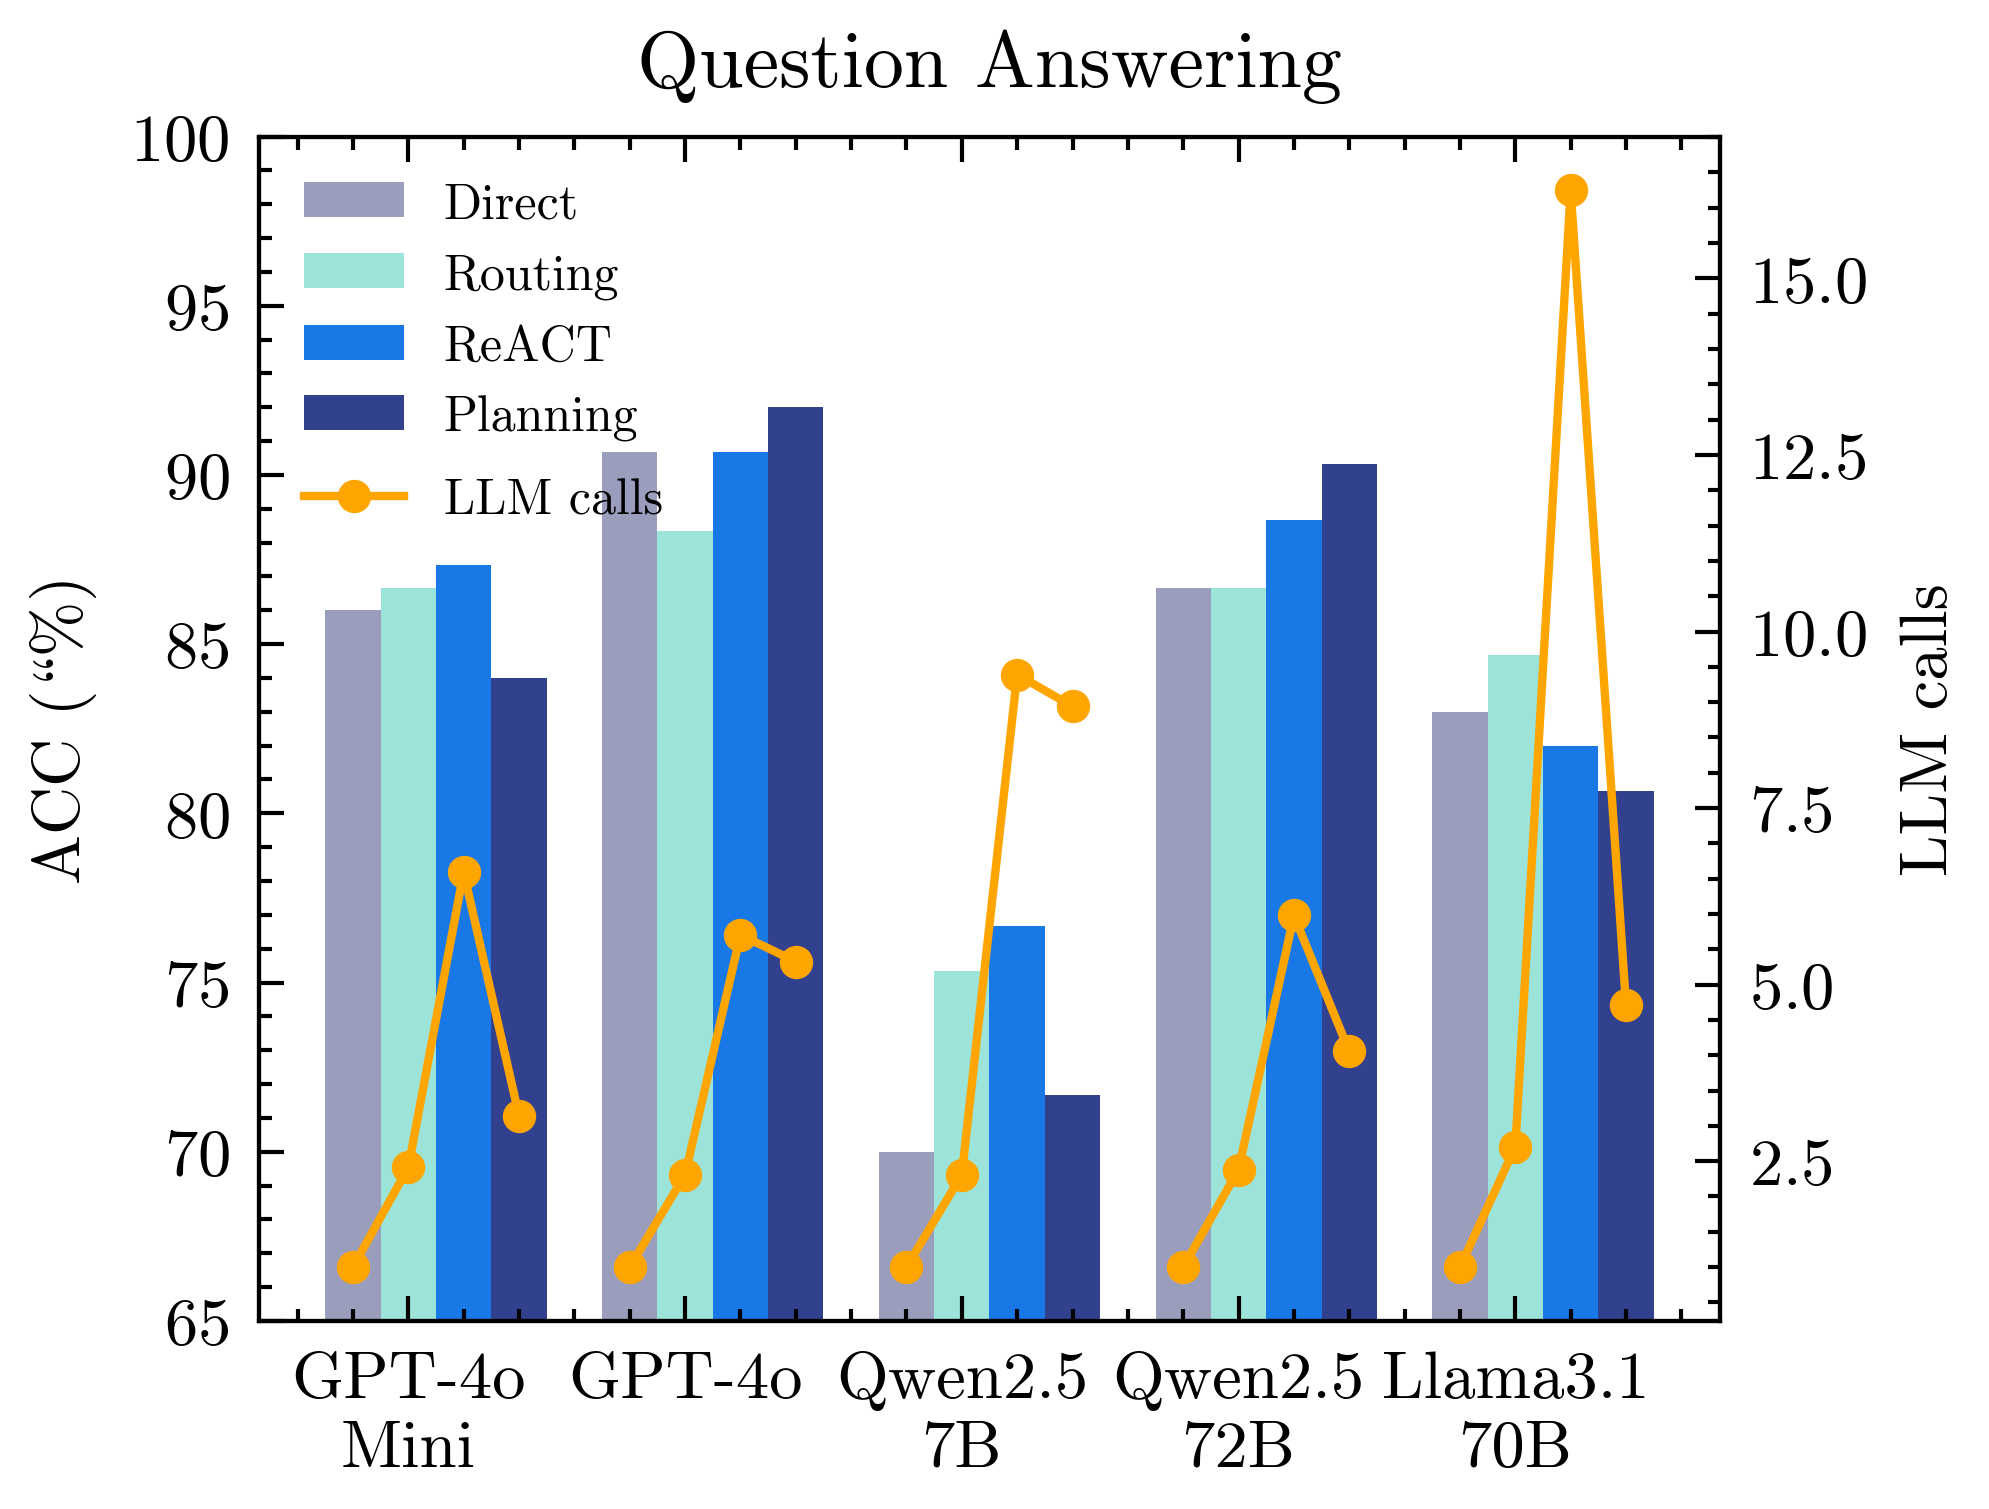

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

plt.style.use(['science','ieee', 'no-latex'])
colors = ["#9b9dbd", "#9ce4d9", "#1778E6", "#32418E"]

x = np.arange(len(llms))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
ax.set_ylabel("ACC (\%)")

for attribute, measurement in acc_data.items():
    offset = width * multiplier
    print(x + offset)
    print(measurement)
    rects = ax.bar(x + offset, measurement, width, label=approach_names[multiplier], color=colors[multiplier])
    # ax.bar_label(rects, padding=3)
    multiplier += 1
ax.legend(fontsize=6, loc="upper left")

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, llm_names)
# ax.legend(loc='upper left', ncols=3)
ax.set_ylim(65, 100)

line_color = "#ffa500"
ax2 = ax.twinx()
ax2.set_ylabel('LLM calls')
start = 0
for i, llm in enumerate(llms):
    x = [start, start + width, start + 2 * width, start + 3 * width]
    if i == 0:
        ax2.plot(x, call_data[llm], marker='.', color=line_color, linestyle="-", label="LLM calls")
    else:
        ax2.plot(x, call_data[llm], marker='.', color=line_color, linestyle="-")
    start = 5 * width + start
ax2.legend(fontsize=6, loc='upper left', bbox_to_anchor=(0,0.75))

plt.title("Question Answering")
plt.savefig("question_answering.pdf", bbox_inches='tight', dpi=300)
plt.show()